In [1]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下載資料集
!unzip food-11.zip # 解壓縮

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: food-11/training/2_849.jpg  
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  inflating: food-11/training/0_569.jpg  
  i

In [ ]:
!mkdir little_ds
!ls

food-11  food-11.zip  little_ds  sample_data


In [ ]:
!cp food-11/validation/*_1.jpg little_ds/.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import torchvision.transforms as transforms
from PIL import Image

import os
import time

In [3]:
class MyDataset(Dataset):
    def __init__(self, file_path, transform, with_label):
        self.transform = transform
        data_list = os.listdir(file_path)
        self.label_container = []
        self.data_container = []
        self.with_label = with_label
        self.data_len = len(data_list)
        for i, data in enumerate(data_list):
            img_dir = file_path + data
            self.data_container.append(img_dir)
            self.label_container.append(int(data.split("_")[0]))
        if self.with_label:
          print("class number: {}".format(len(set(self.label_container))))

    def __getitem__(self, index):
        img = Image.open(self.data_container[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.with_label:
            label = self.label_container[index]
        if self.with_label:
            return img, label
        else:
            return img

    def __len__(self):
        return self.data_len

In [5]:
train_path = './food-11/training/'
test_path = './food-11/testing/'
valid_path = './food-11/validation/'
little_path = './little_ds/'
train_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

train_ds = MyDataset(train_path, transform=train_transform , with_label=True)

class number: 11


<Figure size 432x288 with 0 Axes>

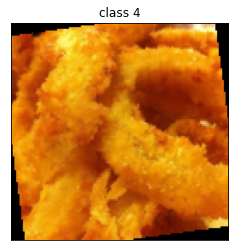

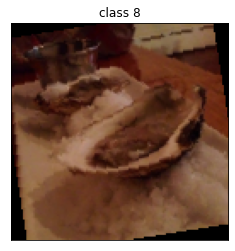

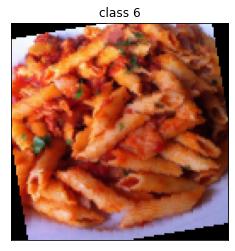

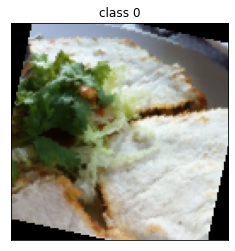

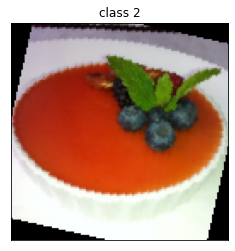

In [6]:
for i in range(5):
  img, label = train_ds[i]
  plt.figure(i)
  fig, ax = plt.subplots()
  ax.imshow(img.permute(1, 2, 0).numpy())
  ax.set_title("class {}".format(label))
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

In [26]:
class ResBlk(nn.Module):
    """resnet block"""
    def __init__(self, ch_in, ch_out, stride=1):
        """
        :param ch_in:
        :param ch_out:
        """
        super(ResBlk, self).__init__()

        # we add stride support for resbok, which is distinct from tutorials.
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()
        if ch_out != ch_in:
            # [b, ch_in, h, w] => [b, ch_out, h, w]
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
            )


    def forward(self, x):
        """
        :param x: [b, ch, h, w]
        :return:
        """
        # print("==")
        out = F.relu(self.bn1(self.conv1(x)))
        # print(out.shape)
        out = self.bn2(self.conv2(out))
        # print(out.shape)
        # short cut.
        # extra module: [b, ch_in, h, w] => [b, ch_out, h, w]
        # element-wise add:
        out = self.extra(x) + out
        out = F.relu(out)
        
        return out

In [27]:
class ResNet18(nn.Module):

    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm2d(64)
        )
        # followed 4 blocks
        # [b, 64, h, w] => [b, 128, h ,w]
        self.blk1 = ResBlk(64, 128, stride=2)
        # [b, 128, h, w] => [b, 256, h, w]
        self.blk2 = ResBlk(128, 256, stride=2)
        # # [b, 256, h, w] => [b, 512, h, w]
        # self.blk3 = ResBlk(256, 512, stride=2)
        # # [b, 512, h, w] => [b, 1024, h, w]
        # self.blk4 = ResBlk(512, 512, stride=1)

        self.outlayer = nn.Linear(256*1*1, 11)

    def forward(self, x):
        """

        :param x:
        :return:
        """
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        # [b, 64, h, w] => [b, 1024, h, w]
        x = self.blk1(x)
        x = self.blk2(x)
        # x = self.blk3(x)
        # x = self.blk4(x)


        # print('after conv:', x.shape) #[b, 512, 2, 2]
        # [b, 512, h, w] => [b, 512, 1, 1]
        x = F.adaptive_avg_pool2d(x, [1, 1])
        # print('after pool:', x.shape)
        x = x.view(x.size(0), -1)
        x = self.outlayer(x)


        return x

In [28]:
epochs = 30
batch_sz = 256
lr = 0.001
iter_show = 1

train_ds = MyDataset(train_path, transform=train_transform , with_label=True)
train_loader = DataLoader(train_ds, batch_size=batch_sz, shuffle=True)

valid_ds = MyDataset(valid_path, transform=test_transform , with_label=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_sz, shuffle=True)

# little_ds = MyDataset(little_path, transform=train_transform, with_label=True)
# little_loader = DataLoader(little_ds, batch_size=batch_sz, shuffle=True)
# train_ds = little_ds
# train_loader = little_loader
# valid_ds = little_ds
# valid_loader = little_loader

device = torch.device('cuda:0')
model = ResNet18().to(device)
criteon = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


class number: 11
class number: 11


In [29]:
def train(epoch):
  model.train()
  train_acc = 0.0
  train_loss = 0.0
  for i, (features, labels) in enumerate(train_loader):
    features, labels = features.to(device), labels.to(device)
    logits = model(features)
    loss = criteon(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    preds = logits.argmax(dim=1)
    num_corrects = torch.eq(preds, labels).sum().float().item()
    accs = num_corrects / features.shape[0]

    train_acc += num_corrects
    train_loss += loss.item()

    if i % iter_show == 0:
      print("epoch [{:>2}/{}], iter [{:>2}/{}], loss {:.4f}, accuracy {:.4f}".format(epoch, epochs, i, len(train_ds)//batch_sz, loss.item()/features.shape[0], accs))
    
  print("[Train] epoch [{:>2}/{}], avg loss {:.4f}, avg acc {:.4f}".format(epoch, epochs, train_loss/len(train_ds), train_acc/len(train_ds)))

def evaluate(epoch):
  model.eval()
  with torch.no_grad():
    total_num = 0
    total_correct = 0
    test_loss = 0.0
    for x, label in valid_loader:
        x, label = x.to(device), label.to(device)
        logits = model(x)
        loss = criteon(logits, label)
        pred = logits.argmax(dim=1)
        total_correct += torch.eq(pred, label).float().sum().item()
        total_num += x.size(0)
        test_loss += loss.item()

    acc = total_correct / total_num
    

    print("[Valid] epoch [{:>2}/{}], avg loss {:.4f}, avg acc {:.4f}".format(epoch, epochs, test_loss/total_num, acc))

In [ ]:
for epoch in range(epochs):
  epoch_start_time = time.time()
  train(epoch)
  evaluate(epoch)
  print("epoch [{:>2}/{}] time {}".format(epoch, epochs, time.time() - epoch_start_time))

epoch [ 0/30], iter [ 0/38], loss 0.0097, accuracy 0.0352
epoch [ 0/30], iter [ 1/38], loss 0.0091, accuracy 0.2070
epoch [ 0/30], iter [ 2/38], loss 0.0089, accuracy 0.1914
epoch [ 0/30], iter [ 3/38], loss 0.0083, accuracy 0.2500
epoch [ 0/30], iter [ 4/38], loss 0.0080, accuracy 0.2578
epoch [ 0/30], iter [ 5/38], loss 0.0082, accuracy 0.2656
epoch [ 0/30], iter [ 6/38], loss 0.0084, accuracy 0.2148
epoch [ 0/30], iter [ 7/38], loss 0.0080, accuracy 0.2539
epoch [ 0/30], iter [ 8/38], loss 0.0081, accuracy 0.2578
epoch [ 0/30], iter [ 9/38], loss 0.0080, accuracy 0.2852
epoch [ 0/30], iter [10/38], loss 0.0077, accuracy 0.3125
epoch [ 0/30], iter [11/38], loss 0.0081, accuracy 0.2500
epoch [ 0/30], iter [12/38], loss 0.0078, accuracy 0.2812
epoch [ 0/30], iter [13/38], loss 0.0080, accuracy 0.2656
epoch [ 0/30], iter [14/38], loss 0.0081, accuracy 0.2969
epoch [ 0/30], iter [15/38], loss 0.0081, accuracy 0.2656
epoch [ 0/30], iter [16/38], loss 0.0079, accuracy 0.2734
epoch [ 0/30],